In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from glob import glob
import os

In [ ]:
def read_xy(path: str):
    df = pd.read_csv(path, skipinitialspace=True)
    df['N'] = df.index + 1
    df['r'] = (df.x ** 2 + df.y ** 2) ** 0.5
    df['cr'] = df.r.cummax()
    df['fd'] = np.log(df.N) / np.log(df.cr)
    df['run'] = os.path.splitext(Path(path).name)[0]

    return df.replace([np.inf, -np.inf], np.nan).dropna()


def read_load(load_dir: str, reader=read_xy):
    paths = glob(f'{load_dir}/*.csv')
    return pd.concat([reader(path) for path in paths])


def read_sp_xy(specific_probability_dir: str):
    probability = float(Path(specific_probability_dir).name)
    df = read_load(specific_probability_dir)
    df['probability'] = probability

    return df


def read_sp(sp_dir: str):
    if not Path(sp_dir).exists():
        raise Exception("Root does not exist")

    return pd.concat([read_sp_xy(specific_probability_dir) for specific_probability_dir in glob(f'{sp_dir}/*')])

In [ ]:
def convergent_tail_index(series, tol):
    diffs = np.abs(np.ediff1d(series))
    for i in range(0, len(diffs)):
        if np.max(diffs[i:]) <= tol:
            return i

    # No convergence found
    return None


def mean_of_tail(series, tol=0.05):
    tail_index = convergent_tail_index(series, tol)
    if tail_index is None:
        raise Exception("No convergence found.")

    return np.mean(series[tail_index:])


def std_of_tail(series, tol=0.05):
    tail_index = convergent_tail_index(series, tol)
    if tail_index is None:
        raise Exception("No convergence found.")

    return np.std(series[tail_index:])


def fd_stats(dfs):
    fds = [mean_of_tail(df.fd, 0.1) for df in dfs]
    fds_clean = [f for f in fds if f < np.inf]
    return np.mean(fds_clean), np.mean(fds_clean) / np.sqrt(fds_clean.length())

In [352]:
def linear(x, a, b):
    return x * a + b

Now we start to read data and generate charts:

In [ ]:
alpha = read_load("../data/alpha")

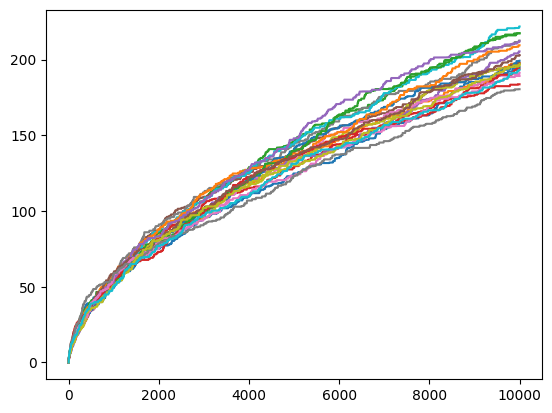

In [373]:
for run, df in alpha.groupby('run'):
    plt.plot(df.N, df.cr)

In [222]:
b1 = alpha.groupby('N').agg({'fd': ['mean', 'std']}).reset_index()

In [224]:
b1['fd_min'] = b1['fd']['mean'] - b1['fd']['std'] / np.sqrt(20)
b1['fd_max'] = b1['fd']['mean'] + b1['fd']['std'] / np.sqrt(20)
b1['fd_mean'] = b1['fd']['mean']

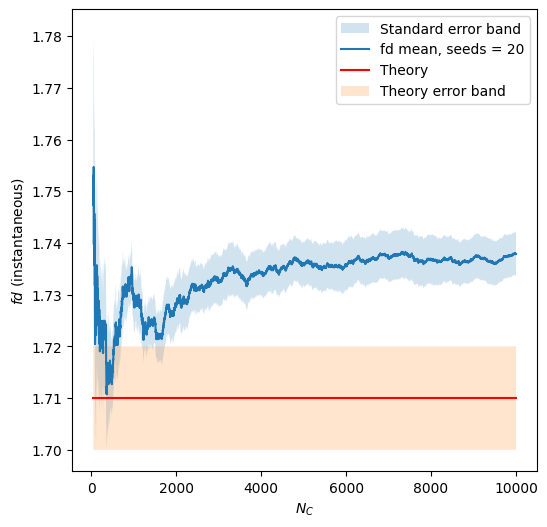

In [268]:
b2 = b1[50:]
fig, ax = plt.subplots(figsize=(6, 6))

plt.fill_between(
    b2.N,
    b2.fd_min,
    b2.fd_max,
    alpha=0.2, label=f"Standard error band"
)
plt.plot(
    b2.N,
    b2['fd']['mean'],
    color='tab:blue', label='fd mean, seeds = 20'
)

plt.plot([50, 10000], [1.71, 1.71], color='red', label='Theory')
plt.fill_between(b2.N, 1.71 - 0.01, 1.71 + 0.01, alpha=0.2, label='Theory error band')

plt.xlabel("$N_C$")
plt.ylabel("$fd$ (instantaneous)")
plt.legend()

plt.savefig('../figures/nc-fd-convergence.svg')
plt.savefig('../figures/nc-fd-convergence.png')
plt.show()

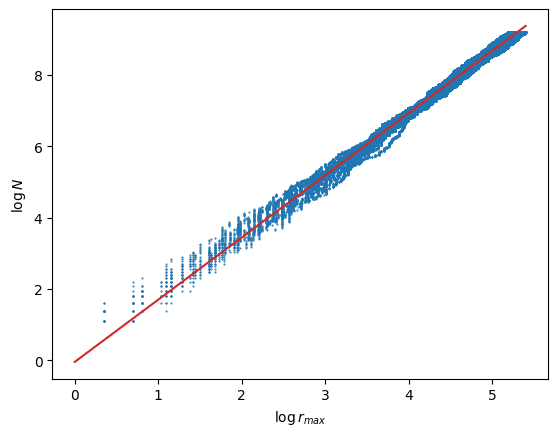

(array([ 1.74367407, -0.04800646]),
 array([[ 2.04560145e-07, -9.71987978e-07],
        [-9.71987978e-07,  4.67541850e-06]]))

In [379]:
without_prefix = alpha[alpha.N > 50]
p, pcov = scipy.optimize.curve_fit(linear, np.log(without_prefix.cr), np.log(without_prefix.N))
linear_extent = np.linspace(0, np.max(np.log(alpha.cr)))

plt.scatter(np.log(alpha.cr), np.log(alpha.N), s=1, marker='.', color="tab:blue")
plt.plot(linear_extent, linear(linear_extent, *p), color="tab:red")

plt.xlabel("$\\log r_{max}$")
plt.ylabel("$\\log N$")

plt.savefig('../figures/rmax-n.svg')
plt.savefig('../figures/rmax-n.png')
plt.show()
p, pcov

In [229]:
(b1['fd_mean'][5000:].mean(), b1['fd_mean'][5000:].std())

(1.7366417607669946, 0.0007487212069864084)

In [327]:
c_sp = read_sp("../data/stick-probability")

/Users/joshuacoles/Library/Caches/pypoetry/virtualenvs/data-analysis-B4Au_hWl-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/joshuacoles/Library/Caches/pypoetry/virtualenvs/data-analysis-B4Au_hWl-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/joshuacoles/Library/Caches/pypoetry/virtualenvs/data-analysis-B4Au_hWl-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/joshuacoles/Library/Caches/pypoetry/virtualenvs/data-analysis-B4Au_hWl-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/joshu

KeyboardInterrupt: 

In [182]:
gg = c_sp.groupby(['probability', 'N'])

In [231]:
ggg = gg.agg(
    overall_fd=('fd', lambda fd: np.mean(fd[-100:])),
    overall_fd_std=('fd', 'std')
)\
    .reset_index()\
    .groupby('probability').agg(fd=('overall_fd', 'mean'), fd_std=('overall_fd_std', lambda std: np.sqrt(np.mean(np.square(std)))))

In [232]:
ggg

fd    fd_std
probability                    
0.01         2.097215  0.083358
0.02         2.065359  0.080450
0.03         2.031527  0.080274
0.04         2.018752  0.079083
0.05         2.004063  0.080021
...               ...       ...
0.96         1.743270  0.068867
0.97         1.739272  0.069956
0.98         1.736224  0.069049
0.99         1.731367  0.070775
1.00         1.733798  0.070582

[100 rows x 2 columns]

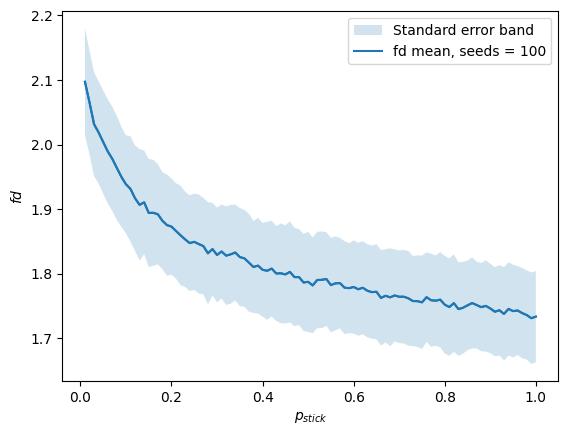

In [236]:
plt.fill_between(ggg.index, ggg.fd - ggg.fd_std, ggg.fd + ggg.fd_std, alpha=0.2, label=f"Standard error band")
plt.plot(ggg.index, ggg.fd, color='tab:blue', label='fd mean, seeds = 100')
plt.plot(ggg.index, ggg.fd)
plt.xlabel("$p_{stick}$")
plt.ylabel("$fd$")
plt.legend()

plt.savefig('../figures/sp-fd.svg')
plt.savefig('../figures/sp-fd.png')
plt.show()

In [323]:
bcd = pd.concat([pd.read_csv(path) for path in glob("../data/alpha-fd/*.csv")])

In [324]:
scipy.polyfit(np.log(bcd.w), np.log(bcd.n_occupied), 1)

/var/folders/yz/hjlw4lyn3rq0s5y_r82b55cw0000gn/T/ipykernel_10820/4287139081.py:1: DeprecationWarning: scipy.polyfit is deprecated and will be removed in SciPy 2.0.0, use numpy.polyfit instead
  scipy.polyfit(np.log(bcd.w), np.log(bcd.n_occupied), 1)


array([-1.39063407,  9.36618136])

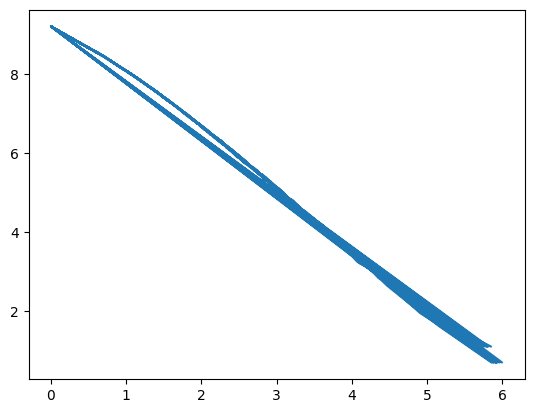

In [325]:
plt.plot(np.log(bcd.w), np.log(bcd.n_occupied))

In [326]:
sel = (np.log(bcd.w) > 2) & (np.log(bcd.w) < 6)
p, _ = scipy.optimize.curve_fit(linear, np.log(bcd[sel].w), np.log(bcd[sel].n_occupied))
p

array([-1.568469  ,  9.81575643])

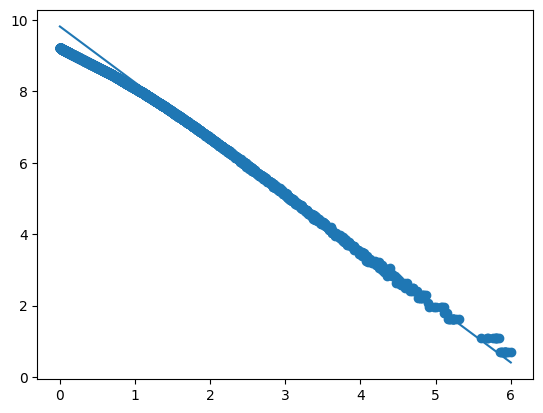

In [322]:
plt.scatter(np.log(bcd.w), np.log(bcd.n_occupied))
plt.plot(np.linspace(0, 6), linear(np.linspace(0, 6), *p))